In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
def set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, sod, sdd):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    origin  = (0., 0.)

    ray_t = np.zeros((N_angle * N_offset, 2))  # Ray origin
    ray_n = np.zeros((N_angle * N_offset, 2))  # Ray direction

    # Compute rays for each angle
    for i in range(N_angle):
        theta = angles[i]
        
        # Compute source position (on a circular path)
        source = np.array([sod * np.cos(theta), sod * np.sin(theta)])

        # Define detector arc (equally spaced points)
        detector_offsets = 1.5* np.linspace(-N_side/2, N_side/2, N_offset)
        
        detector_x = detector_offsets * np.cos(theta + np.pi / 2)
        detector_y = detector_offsets * np.sin(theta + np.pi / 2)
        
        detectors = np.stack([detector_x, detector_y], axis=1)  # Shape: (N_detectors, 2)

        # Compute ray directions
        start_idx = i * N_offset
        ray_t[start_idx:start_idx + N_offset, :] = source + np.array([N_side/2, N_side/2])
        ray_n[start_idx:start_idx + N_offset, :] = detectors - sdd*np.array([np.cos(theta), np.sin(theta)])  # Shape: (N_detectors, 2)
        
        # Normalize directions
        norm_factor = np.linalg.norm(ray_n[start_idx:start_idx + N_offset], axis=1, keepdims=True)
        ray_n[start_idx:start_idx + N_offset] /= norm_factor


    # Convert to CuPy for GPU acceleration
    t_spec = cp.array(ray_t)
    n_spec = cp.array(ray_n)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    print('arg_shape', arg_shape,
            't_spec', t_spec.shape,
            'tshape', t_spec.shape,
            'n_spec', n_spec.shape,
            'nshape', n_spec.shape,
            'pitch_op', pitch_op,
            'origin', origin)
    return op_pixels, op_splines_1, op_splines_2



def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

### check adjoint match

In [13]:
op_pixels, op_splines_1, op_splines_2 = set_operators_fan_beam(500, 700, 500, (1.,1.), (500,500), 6000, 7500) #sod sdd

arg_shape (500, 500) t_spec (350000, 2) tshape (350000, 2) n_spec (350000, 2) nshape (350000, 2) pitch_op (1.0, 1.0) origin (0.0, 0.0)


In [35]:
op = op_splines_1
x = cp.random.rand(500, 500, dtype=cp.float64).reshape(-1)
print('x shape', x.shape, 'dtype', x.dtype)
Ax = op.apply(x)
print('Ax shape', Ax.shape, 'dtype', Ax.dtype)
y = cp.random.rand(Ax.shape[0]).reshape(-1)
print('y shape', y.shape, 'dtype', y.dtype)
Aty = op.adjoint(y)
print('Aty shape', Aty.shape, 'dtype', Aty.dtype)

print('<Ax,y>', cp.dot(Ax, y))
print('<x,Aty>', cp.dot(x, Aty))
print('rel error', cp.linalg.norm(cp.dot(Ax, y) - cp.dot(x, Aty)) / cp.linalg.norm(cp.dot(Ax, y)))

x shape (250000,) dtype float64
Ax shape (350000,) dtype float64
y shape (350000,) dtype float64
Aty shape (250000,) dtype float64
<Ax,y> 35987343.084387206
<x,Aty> 35987307.50304946
rel error 9.88718107337691e-07


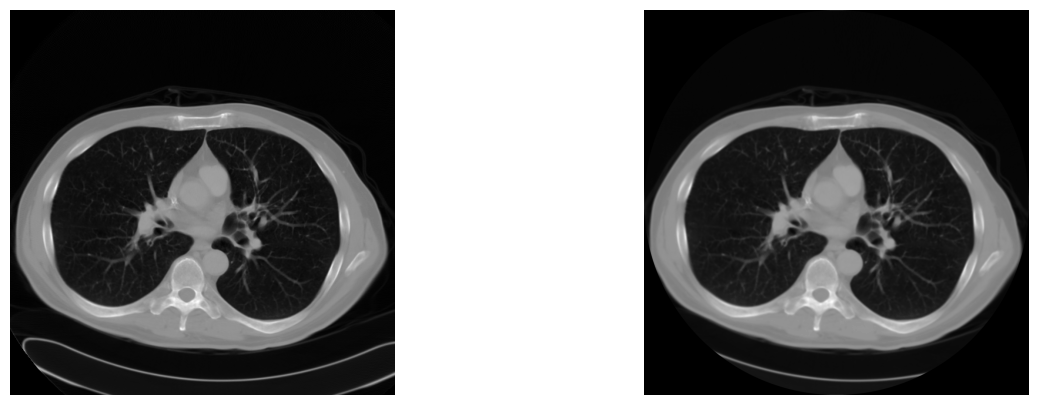

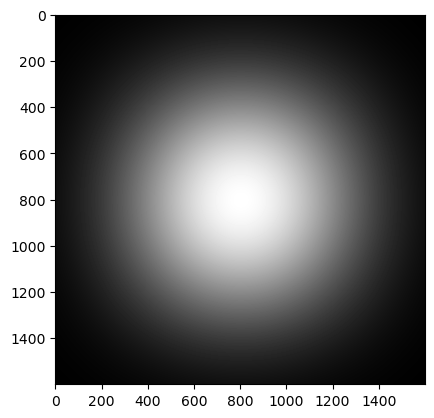

In [2]:
import astra 

N_side = 3000
N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
random_phantom = io.imread(image_path)[12:512, :500]
oversampling = 500
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same') #comment

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 1
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom*mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()
phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 

    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = 1.5*N_side/N_offset
    proj_geom = astra.create_proj_geom('fanflat', det_spacing, N_offset, angles, 6000, 1500)#source_origin, origin_det
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    sinogram_id, y_data_astra = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data_astra).reshape(-1) #+ 1*cp.random.randn(N_angle*N_offset)

    #y_data_astra = op_splines_2.apply(phantom.reshape(-1)).reshape((N_angle, N_offset)).get()
    
    ####### rec astra ########
    
    proj_geom = astra.create_proj_geom('fanflat', 1.5/(N_offset/oversampling) , N_offset, angles, 6000*oversampling/N_side, 1500*oversampling/N_side)#source_origin, origin_det
    vol_geom  = astra.create_vol_geom(oversampling,oversampling)

    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    sino_id   = astra.data2d.create('-sino', proj_geom, y_data_astra)
    rec_id    = astra.data2d.create('-vol', vol_geom)

    cfg       = astra.astra_dict('CGLS_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId']      = sino_id
    cfg['ProjectorId']          = proj_id

    alg_id    = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 30)
    rec_astra              = astra.data2d.get(rec_id)
    ############################


    stop_crit = pxst.MaxIter(30)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, 6000, 7500) #sod sdd

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling


    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]

    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')

    #for astra, use pixels also
    full_im_astra = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_astra[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_astra[i, j]

    full_im_astra = fftconvolve(full_im_astra, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    ax[3].imshow(full_im_astra, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    loss4 = psnr(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra))

    ssim1 = ssim(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix), data_range=2)
    ssim2 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1), data_range=2)
    ssim3 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2), data_range=2)
    ssim4 = ssim(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra), data_range=2)
    
    plt.show()
    
    return loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4


In [ ]:
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500, 1000]
oversamplings =[20, 40, 50, 100, 150]

losses1 = []
losses2 = []
losses3 = []
losses4 = []

ssims1 = []
ssims2 = []
ssims3 = []
ssims4 = []

images_pix = []
images_spline1 = []
images_spline2 = []
images_astra = []

for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4 = run_xp(int(2*oversampling), int(1*oversampling), oversampling, phantom)
    losses1.append(loss1)
    losses2.append(loss2)
    losses3.append(loss3)
    losses4.append(loss4)
    ssims1.append(ssim1)
    ssims2.append(ssim2)
    ssims3.append(ssim3)
    ssims4.append(ssim4)


    images_pix.append(full_im_pix)
    images_spline1.append(full_im_spline1)
    images_spline2.append(full_im_spline2)
    images_astra.append(full_im_astra)
    
    print('Losses : ', loss1, loss2, loss3, loss4)
    print('SSIM : ', ssim1, ssim2, ssim3, ssim4)

Oversampling :  20


NameError: name 'run_xp' is not defined

In [5]:
#save everything
np.save('oversamplings.npy', oversamplings)
np.save('losses1_cone.npy', losses1)
np.save('losses2_cone.npy', losses2)
np.save('losses3_cone.npy', losses3)
np.save('losses4_cone.npy', losses4)
np.save('ssims1_cone.npy', ssims1)
np.save('ssims2_cone.npy', ssims2)
np.save('ssims3_cone.npy', ssims3)
np.save('ssims4_cone.npy', ssims4)
'''
np.save('images_pix.npy', images_pix)
np.save('images_spline1.npy', images_spline1)
np.save('images_spline2.npy', images_spline2)
np.save('images_astra.npy', images_astra)'''

"\nnp.save('images_pix.npy', images_pix)\nnp.save('images_spline1.npy', images_spline1)\nnp.save('images_spline2.npy', images_spline2)\nnp.save('images_astra.npy', images_astra)"

In [4]:
#load everything
oversamplings = np.load('oversamplings.npy')
losses1 = np.load('losses1.npy')
losses2 = np.load('losses2.npy')
losses3 = np.load('losses3.npy')
losses4 = np.load('losses4.npy')
ssims1 = np.load('ssims1.npy')
ssims2 = np.load('ssims2.npy')
ssims3 = np.load('ssims3.npy')
ssims4 = np.load('ssims4.npy')
images_pix = np.load('images_pix.npy')
images_spline1 = np.load('images_spline1.npy')
images_spline2 = np.load('images_spline2.npy')
images_astra = np.load('images_astra.npy')

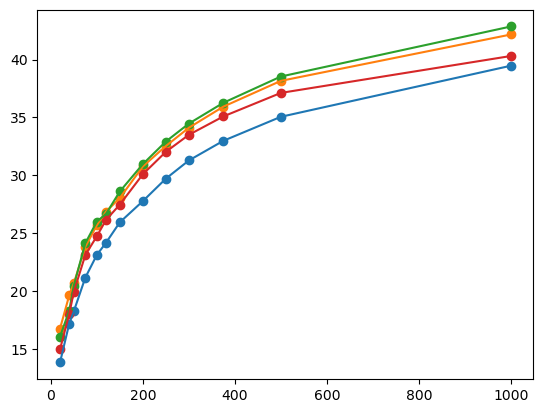

In [6]:

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels psnr')
plt.plot(oversamplings, losses2, label='Box-splines 1 psnr')
plt.plot(oversamplings, losses3, label='Box-splines 2 psnr')
plt.plot(oversamplings, losses4, label='Astra psnr')

plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
plt.scatter(oversamplings, losses4)
# max of y is 40
#plt.legend()
plt.show()

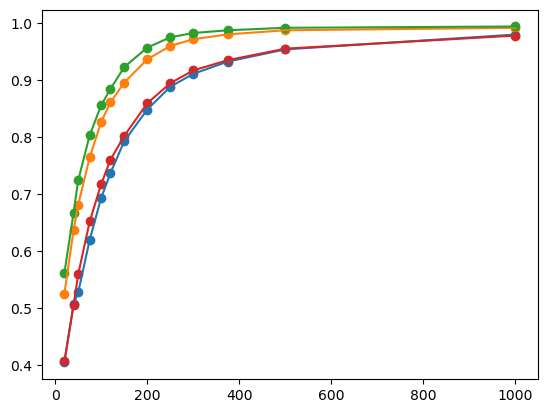

In [7]:
plt.figure('SSIM')
plt.plot(oversamplings, ssims1, label='Pixels ssim')
plt.plot(oversamplings, ssims2, label='Box-splines 1 ssim')
plt.plot(oversamplings, ssims3, label='Box-splines 2 ssim')
plt.plot(oversamplings, ssims4, label='Astra ssim')

plt.scatter(oversamplings, ssims1)
plt.scatter(oversamplings, ssims2)
plt.scatter(oversamplings, ssims3)
plt.scatter(oversamplings, ssims4)

0 0
3.987514179639356e-15 0.8458243513556175
0 1
0.0 0.6889546867386873
0 2
0.0 0.6663557903466681
0 3
0.0 0.4380331328649452
0 4
0.0 0.3295191669381407


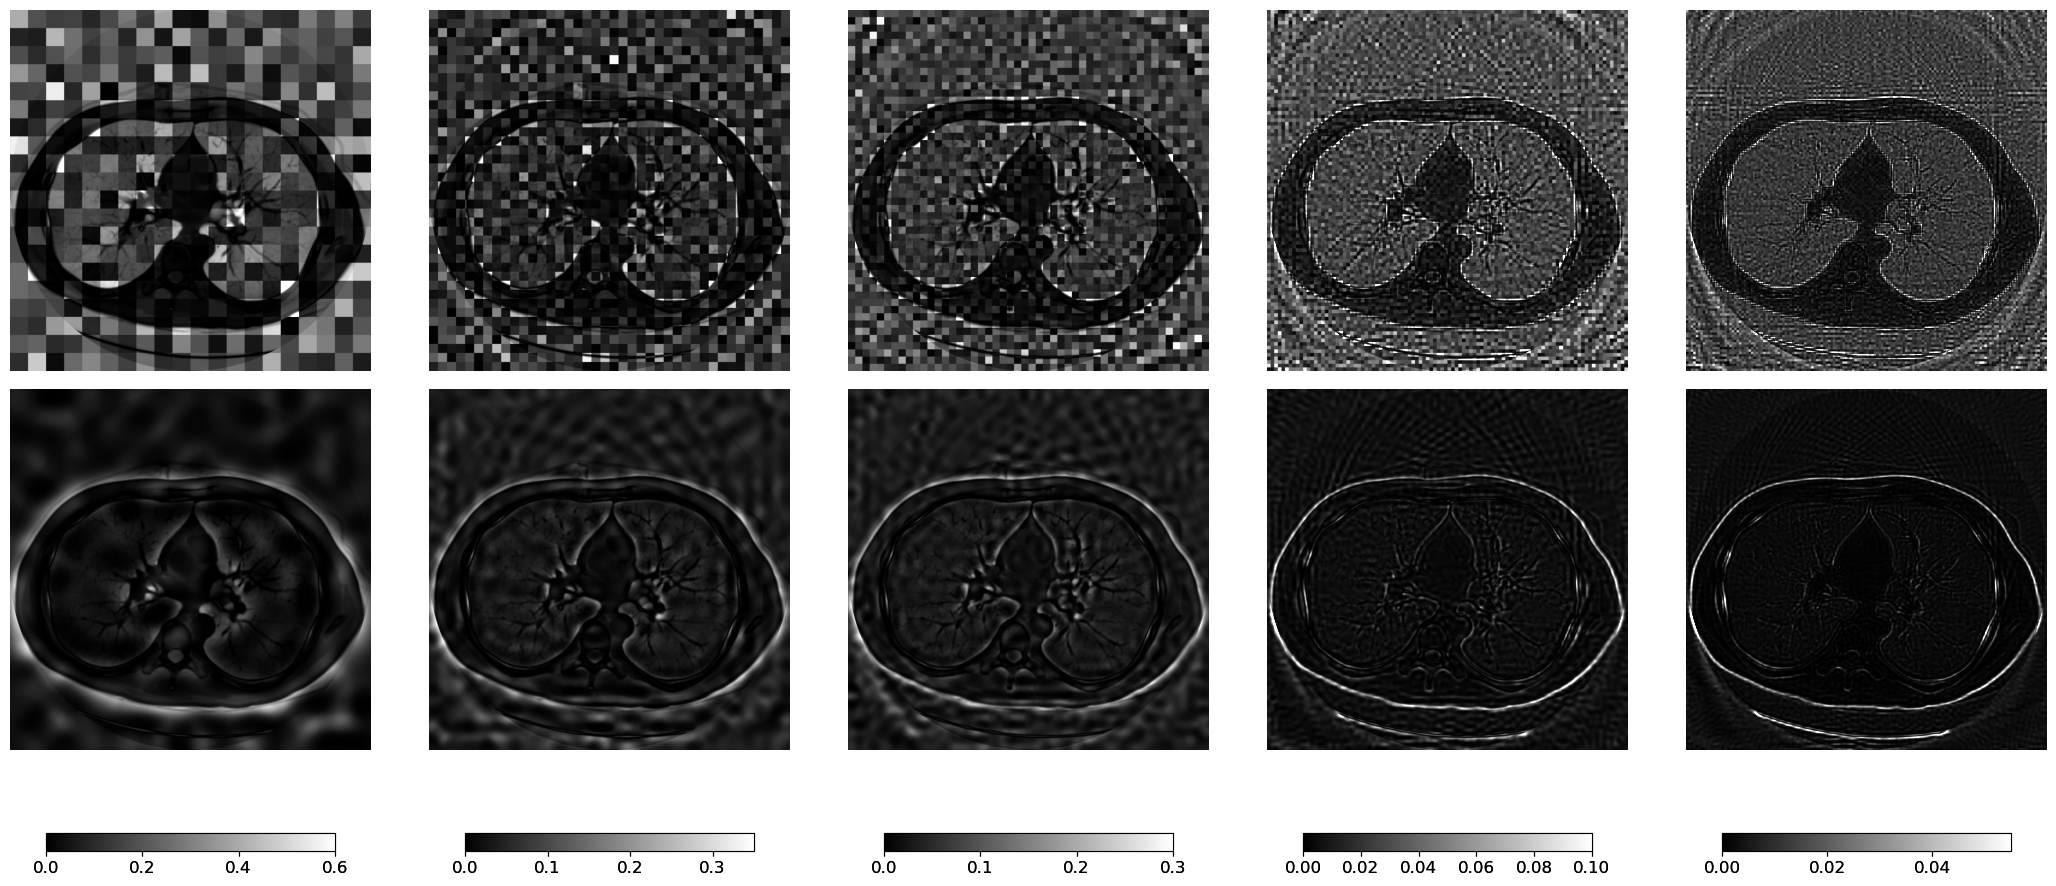

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500, 1000]

# Create figure and subplots
fig, ax = plt.subplots(2, 5, figsize=(10*5/2, 10))
k = 0

# Define the zoom-in region (adjust these values based on your images)
x1, x2, y1, y2 = 1000, 1800, 600, 1400  # Example: Region to zoom into
vmin = 0.0  # Minimum value for colormap
vmax = 1.0  # Maximum value for colormap

for i in range(len(oversamplings)):
    if i in [0, 1, 2, 4, 6]:#, 12]:  # Select specific oversampling values
        images = [images_astra[i], images_spline2[i]]
        # if k == 0:
        #     vmax = 0.5
        # if k == 1:
        #     vmax = 0.25
        # if k == 2:
        #     vmax = 0.25
        # if k == 3:
        #     vmax = 0.08
        # if k == 4:
        #     vmax = 0.03
        # for **2.5

        if k == 0:
            vmax = 0.6
        if k == 1:
            vmax = 0.35
        if k == 2:
            vmax = 0.3
        if k == 3:
            vmax = 0.1
        if k == 4:
            vmax = 0.055
            
        for row in range(2):
            
            im1_ = images[row]#[1000:2500 , 650:2150]
            im1 = (im1_ - np.min(im1_)) / (np.max(im1_) - np.min(im1_))
            im2_ = phantom.get()#[1000:2500 , 650:2150]
            im2 = (im2_ - np.min(im2_)) / (np.max(im2_) - np.min(im2_))
            diff = np.abs(im1-im2)**2.1

            ax[row, k].imshow(diff, cmap='gray', vmax=vmax)
            ax[row, k].axis('off')

            cax = inset_axes(ax[1, k],
                 width="80%", height="5%",
                 loc='lower center',
                 bbox_to_anchor=(0, -0.3, 1, 1),
                 bbox_transform=ax[1, k].transAxes)

            cb = fig.colorbar(
                plt.cm.ScalarMappable(cmap='gray', norm=plt.Normalize(vmin=0, vmax=vmax)),
                cax=cax,
                orientation='horizontal'
            )
            #ticks of size 15 with font latex
            cb.ax.tick_params(labelsize=12)

            if row == 0:
                print(row, k)
                print(diff.min(), diff.max())
            
        k += 1
plt.subplots_adjust(left=0.01, right=0.84, top=0.99, bottom=0.25, wspace=0.05, hspace=0.05)
plt.savefig('table_img2_cone_differences.eps', format='eps')
plt.show()

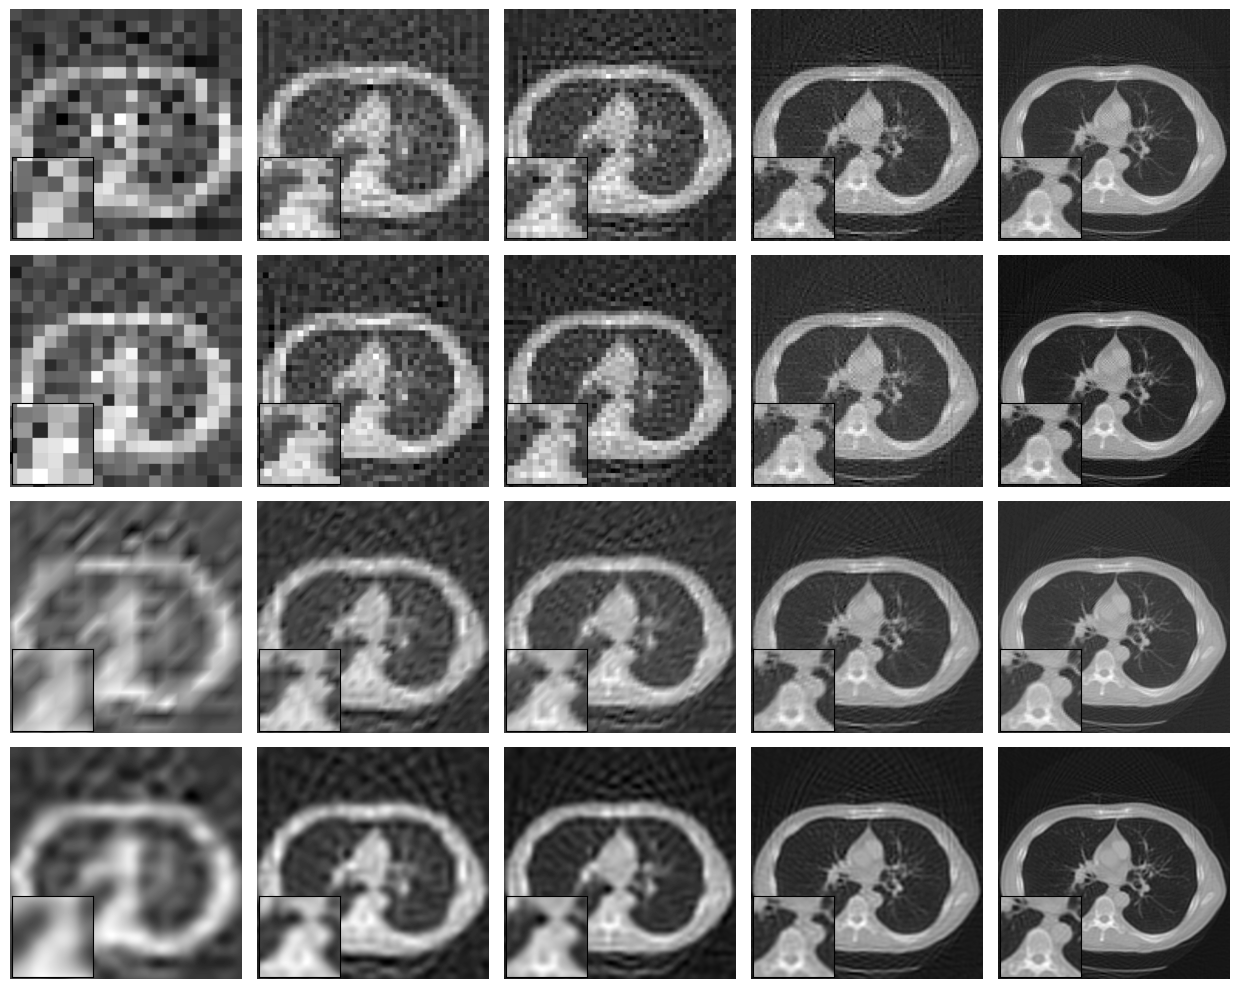

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and subplots
fig, ax = plt.subplots(4, 5, figsize=(10*5/4, 10))
k = 0

# Define the zoom-in region (adjust these values based on your images)
x1, x2, y1, y2 = 1000, 1800, 600, 1400  # Example: Region to zoom into

for i in range(len(oversamplings)):
    if i in [0, 1, 2, 4, 6]:#, 12]:  # Select specific oversampling values
        images = [images_pix[i], images_astra[i], images_spline1[i], images_spline2[i]]
        
        for row in range(4):
            # Display main image
            ax[row, k].imshow(images[row], cmap='gray')
            ax[row, k].axis('off')

            # Add inset for zoomed-in view
            axins = ax[row, k].inset_axes([0.01, 0.01, 0.35, 0.35])  # (x, y, width, height)
            #remove ticks
            axins.set_xticks([])
            axins.set_yticks([])

            # Display zoomed-in region
            axins.imshow(images[row], cmap='gray', extent=[0, images[row].shape[1], 0, images[row].shape[0]])

            # Define zoom region
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins

        k += 1

        #tight layout
plt.tight_layout()
plt.savefig('table_img2_cone.eps', format='eps')
plt.show()


In [2]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark


cp.cuda.Device(0).use()
from pixe_pyxu import *

In [3]:
dataset, dws = "bin2", 2
rx_pitch = (127e-3, 127e-3)  # 0.127 [mm] detector/receiver pitch (height, width)
# Load setup parameters from disk. ========================================
froot = plib.Path("~/pixe/M2EA99-000").expanduser()
fpath = froot / dataset
shiftcorr_value = -0.293 #precalculated shift correction value, below is code to calculate it
print('shift correction value: ', shiftcorr_value)

shift correction value:  -0.293


In [4]:
rec, P, op = reconstruct(fpath, dataset, dws, rx_pitch, method = 'pinv', roi='False', shift_cor=shiftcorr_value, center_slice='True', max_iter=25, damp=0.001) #200 it, damp=2 for pinv | for tv damp=damp=0.001

...reconstruction
projections shape:  (800, 920, 728)
...setting operator
sod:  96.4597 sdd:  765.755 v_shape:  (640, 840, 640) v_pitch:  (0.0319955, 0.0319955, 0.0319955) rx_pitch:  (0.127, 0.127) dws:  2 roi:  False shift_cor:  -0.293 center_slice:  True


/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


Reconstruction shape: (640, 1, 640)


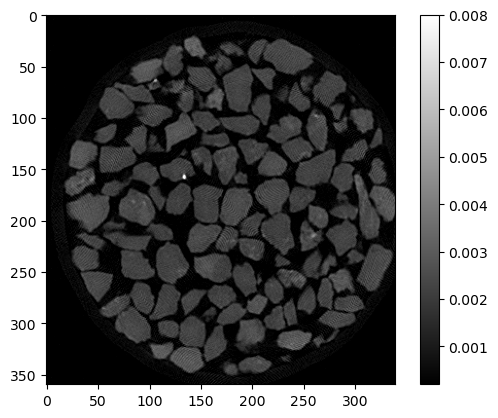

In [6]:
print('Reconstruction shape:', rec.get().shape)
plt.figure()
plt.imshow(rec.get()[120:480, 0, 130:470], cmap='gray', vmin=0.0002, vmax=0.008)
plt.colorbar()
plt.show()

In [96]:
rec_pyxu = rec.get()

In [97]:
rec_pyxu_0degree = rec_pyxu.copy()

In [94]:
import astra

sod=  96.4597/0.0319955
sdd= 765.755 /0.0319955
v_shape= 640 
v_pitch= 0.0319955
rx_pitch= 0.127/0.0319955*2

shift_det = shiftcorr_value /0.0319955
N_view, N = P.shape
angles = np.linspace(0, 2 * cp.pi, num=N_view, endpoint=False) #+ cp.pi


proj_geom = astra.create_proj_geom('fanflat', rx_pitch, N, angles, sod, sdd-sod) #source_origin, origin_det
vol_geom  = astra.create_vol_geom(v_shape,v_shape)

proj_geom = astra.geom_postalignment(proj_geom, shift_det)
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

sino_id   = astra.data2d.create('-sino', proj_geom, P.get())
rec_id    = astra.data2d.create('-vol', vol_geom)

cfg       = astra.astra_dict('CGLS_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId']      = sino_id
cfg['ProjectorId']          = proj_id

alg_id    = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 25)
rec_astra              = astra.data2d.get(rec_id).T

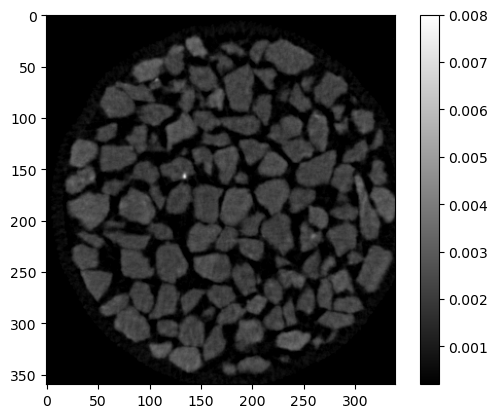

In [95]:
plt.figure()
plt.imshow(rec_astra[120:480, 130:470], cmap='gray', vmin=0.0002, vmax=0.008)
plt.colorbar()
plt.show()

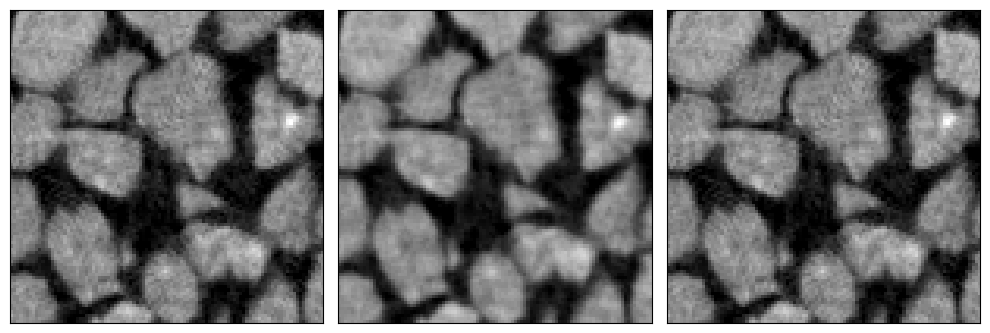

In [98]:
'''plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rec.get()[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 2, 2)
plt.imshow(rec_astra[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()'''

plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(rec_pyxu[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 3, 2)
plt.imshow(rec_astra[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 3, 3)
plt.imshow(rec_pyxu_0degree[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig('4astra_vs_splines_1_xp.eps', format='eps')
plt.show()

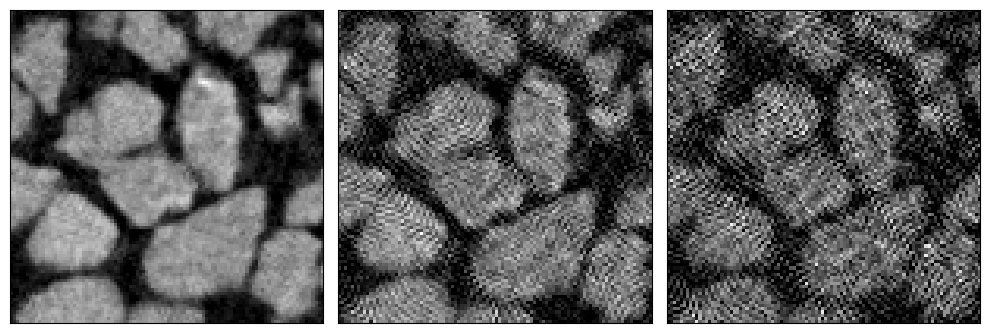

In [8]:
'''
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rec.get()[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 2, 2)
plt.imshow(rec_astra[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()
'''
plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(rec_pyxu[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 3, 2)
plt.imshow(rec_astra[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 3, 3)
plt.imshow(rec_pyxu_0degree[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig('4astra_vs_splines_2_xp.eps', format='eps')
plt.show()

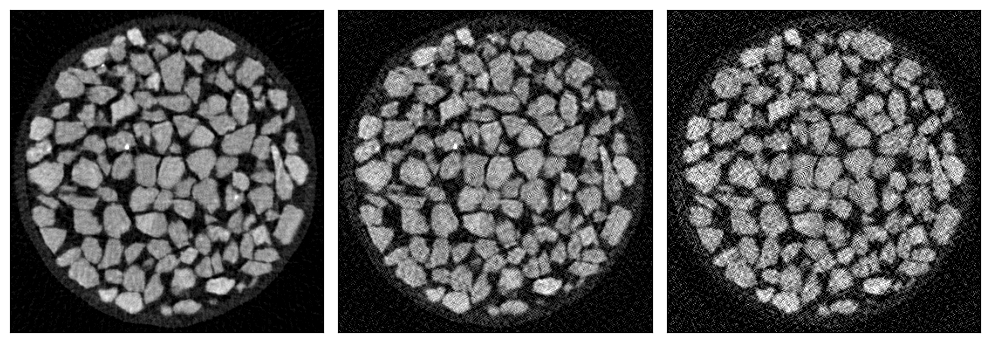

In [9]:
plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(rec_pyxu[120:490, 130:490], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 3, 2)
plt.imshow(rec_astra[120:490, 130:490], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(1, 3, 3)
plt.imshow(rec_pyxu_0degree[120:490, 130:490], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig('4astra_vs_splines_full_xp.eps', format='eps')
plt.show()

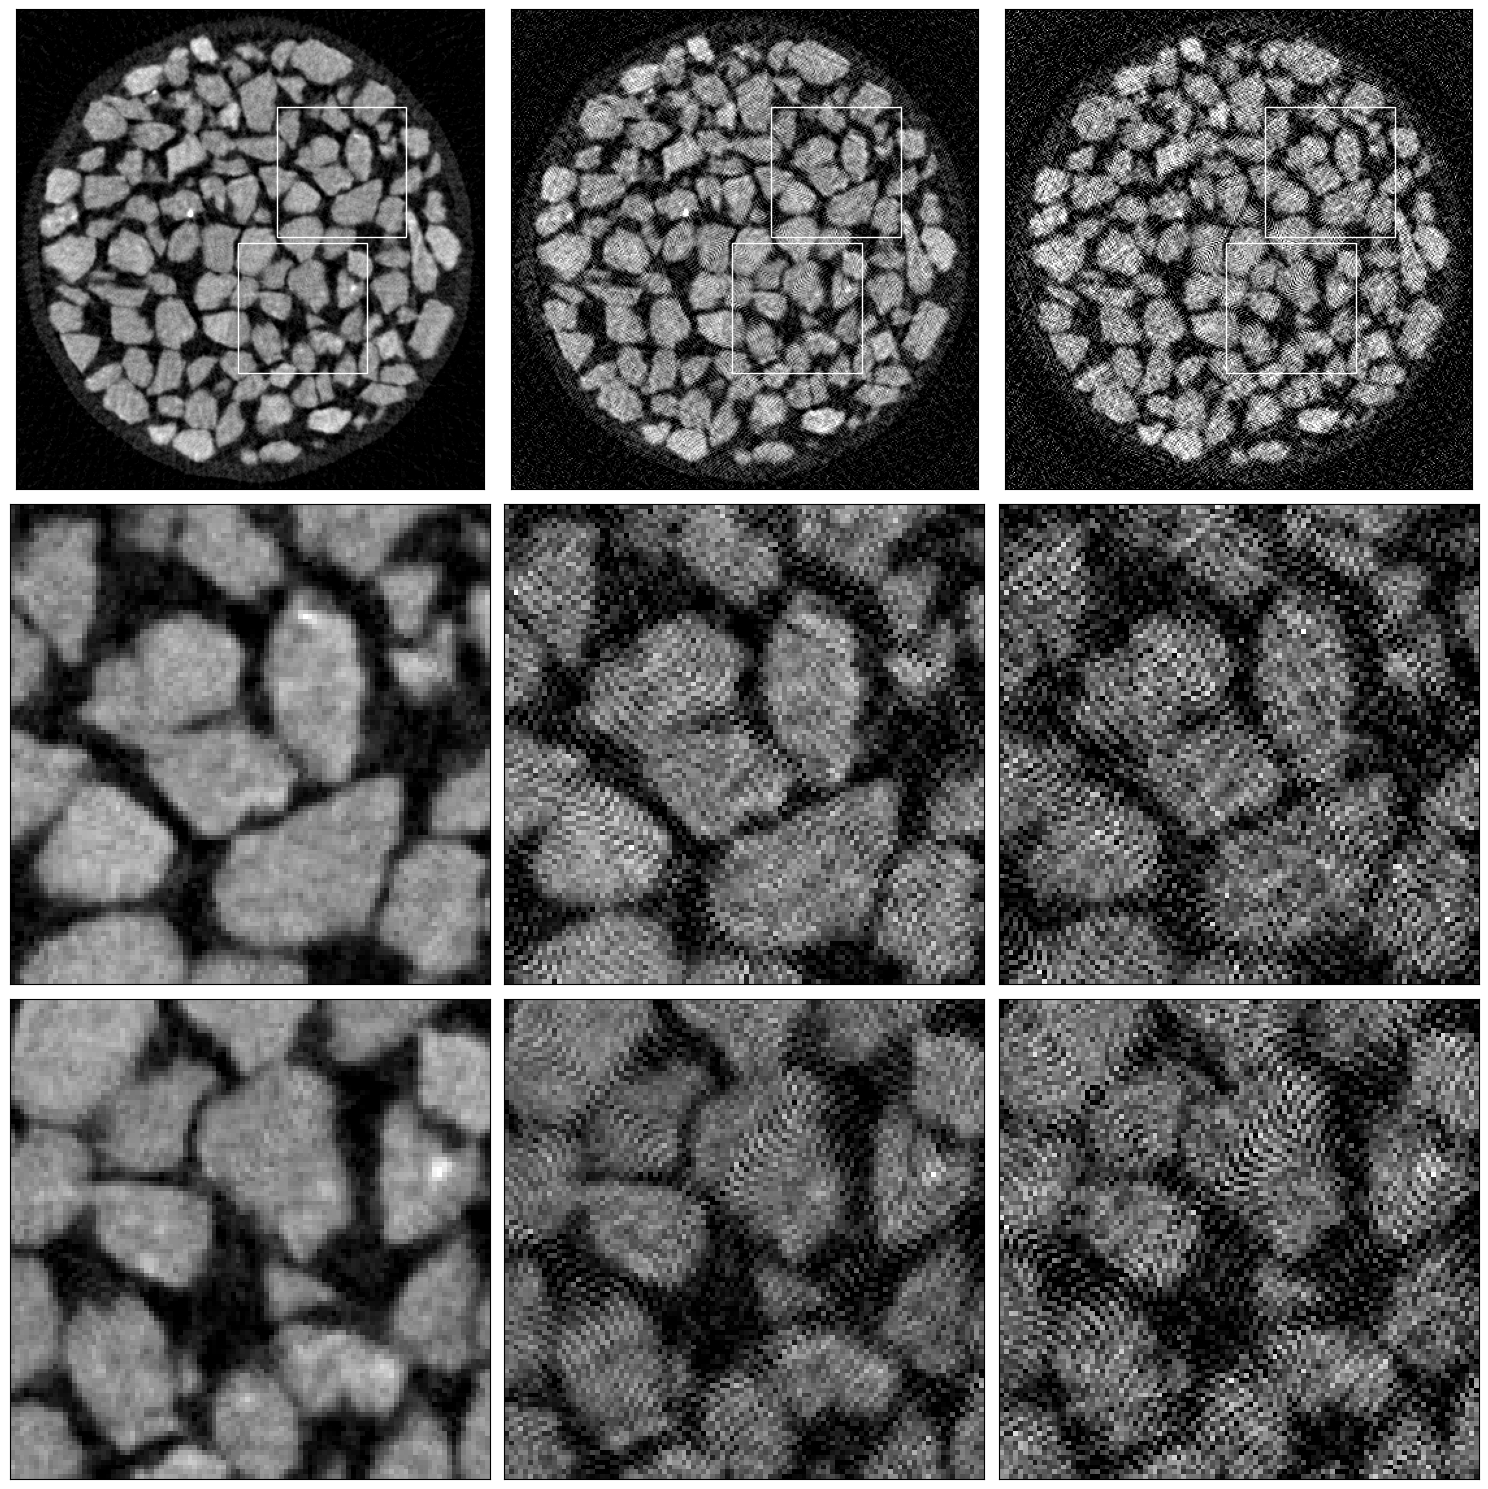

In [26]:
from matplotlib import patches
# all nine figures together
plt.subplots(3, 3, figsize=(15, 15))

plt.subplot(3, 3, 1)
plt.imshow(rec_pyxu[120:490, 130:490], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
rect = patches.Rectangle((200, 75), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)
rect2 = patches.Rectangle((170, 180), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect2)

plt.subplot(3, 3, 2)
plt.imshow(rec_astra[120:490, 130:490], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
rect = patches.Rectangle((200, 75), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)
rect2 = patches.Rectangle((170, 180), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect2)

plt.subplot(3, 3, 3)
plt.imshow(rec_pyxu_0degree[120:490, 130:490], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
rect = patches.Rectangle((200, 75), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)
rect2 = patches.Rectangle((170, 180), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect2)
plt.subplot(3, 3, 4)
plt.imshow(rec_pyxu[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(3, 3, 5)
plt.imshow(rec_astra[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(3, 3, 6)
plt.imshow(rec_pyxu_0degree[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(3, 3, 7)
plt.imshow(rec_pyxu[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(3, 3, 8)
plt.imshow(rec_astra[300:400, 300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(3, 3, 9)
plt.imshow(rec_pyxu_0degree[300:400,    300:400], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig('4astra_vs_splines_all_xp_cropped.eps', format='eps')
plt.show()

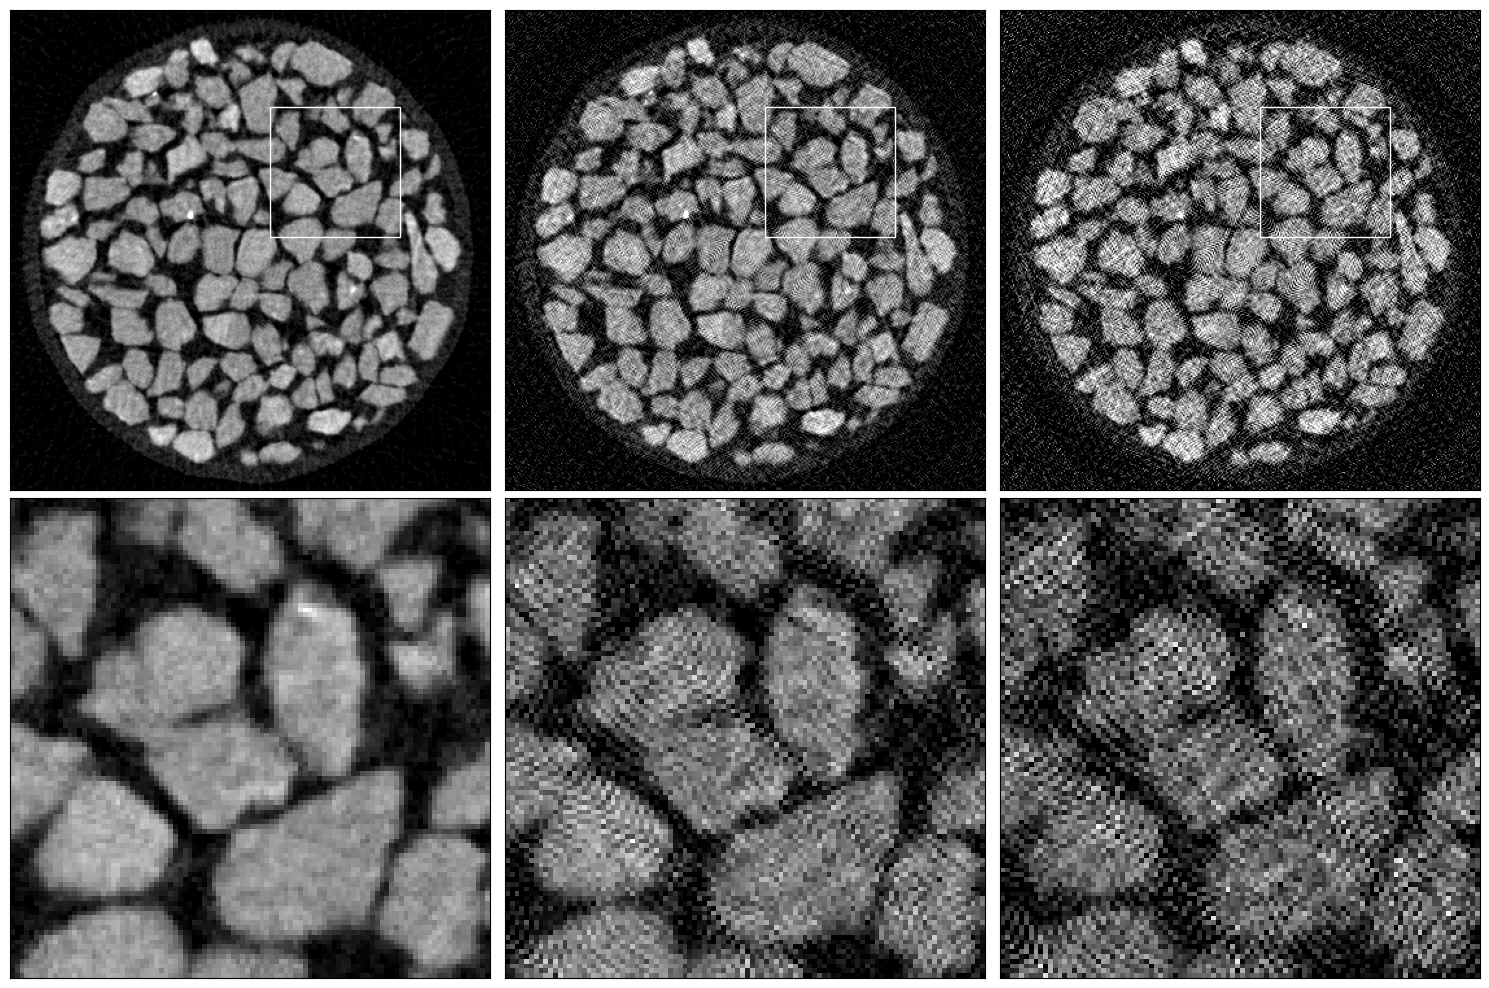

In [34]:
#same as above but with only the two first rows. so do not draw the second rectangle
plt.subplots(2, 3, figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(rec_pyxu[120:490, 125:495], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
rect = patches.Rectangle((200, 75), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)
plt.subplot(2, 3, 2)
plt.imshow(rec_astra[120:490, 125:495], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
rect = patches.Rectangle((200, 75), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)
plt.subplot(2, 3, 3)
plt.imshow(rec_pyxu_0degree[120:490, 125:495], cmap='gray', vmax=0.0039, vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
rect = patches.Rectangle((200, 75), 100, 100, linewidth=1, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)
plt.subplot(2, 3, 4)
plt.imshow(rec_pyxu[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(2, 3, 5)
plt.imshow(rec_astra[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.subplot(2, 3, 6)
plt.imshow(rec_pyxu_0degree[195:295, 330:430], cmap='gray', vmin=-0.0001)
plt.tick_params( bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig('4astra_vs_splines_xp_cropped.eps', format='eps')
plt.show()

In [ ]:
#save reconstructions as npy files
#np.save('rec_pyxu_paper_miss4.npy', rec.get())
#np.save('rec_pyxu_paper_0degree_miss4.npy', rec.get()[:, 0, :])
#np.save('rec_astra_paper_miss4.npy', rec_astra)

In [33]:
rec_astra = np.load('rec_astra_paper_miss4.npy') #_miss4
rec_pyxu = np.load('rec_pyxu_paper_miss4.npy')
rec_pyxu_0degree = np.load('rec_pyxu_paper_0degree_miss4.npy')

In [41]:
from scipy.signal import fftconvolve
from skimage.transform import resize


N_side = 3000
N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')

oversampling = 100
final_size = 3000
factor = final_size//oversampling
rec_spline = rec.get()[300:400, 300:400]
spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

rec_splines2_bis = fftconvolve(full_im_spline, spline_basis, mode='same')



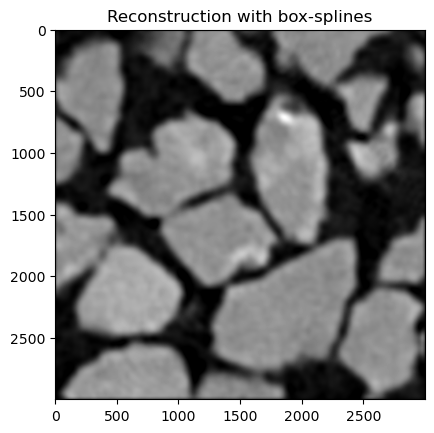

In [27]:
plt.figure()
plt.imshow(rec_splines2, cmap='gray', vmin=-0.0001)
plt.title('Reconstruction with box-splines')
plt.show()

### check adjoint mismatch astra

In [ ]:
import astra

sod=  96.4597/0.0319955
sdd= 765.755 /0.0319955
v_shape= 640 
v_pitch= 0.0319955
rx_pitch= 0.127/0.0319955*2

y = np.random.rand(P.shape[0], P.shape[1])

shift_det = shiftcorr_value/0.0319955
N_view, N = P.shape
angles = np.linspace(0, 2 * cp.pi, num=N_view, endpoint=False)
proj_geom = astra.create_proj_geom('fanflat', rx_pitch, N, angles, sod, sdd-sod) #source_origin, origin_det
vol_geom  = astra.create_vol_geom(v_shape,v_shape)
proj_geom = astra.geom_postalignment(proj_geom, shift_det)

proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

sino_id   = astra.data2d.create('-sino', proj_geom, y)
rec_id    = astra.data2d.create('-vol', vol_geom)
cfg       = astra.astra_dict('BP_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId']     = sino_id
cfg['ProjectorId']          = proj_id
alg_id    = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 1)
Aty              = astra.data2d.get(rec_id)

x = np.random.rand(v_shape, v_shape)
volume_id = astra.data2d.create('-vol', vol_geom, x)
sinogram_id = astra.data2d.create('-sino', proj_geom, 0)
cfg       = astra.astra_dict('FP_CUDA')
cfg['ProjectionDataId']     = sino_id
cfg['VolumeDataId']          = volume_id   
alg_id    = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 1)
Ax             = astra.data2d.get(sino_id)

print('<Ax,y>', cp.dot(Ax.reshape(-1), y.reshape(-1)))
print('<x,Aty>', cp.dot(x.reshape(-1), Aty.reshape(-1)))
print('rel error', cp.linalg.norm(cp.dot(Ax.reshape(-1), y.reshape(-1)) - cp.dot(x.reshape(-1), Aty.reshape(-1))) / cp.linalg.norm(cp.dot(Ax.reshape(-1), y.reshape(-1))))


<Ax,y> 102418228.7057592
<x,Aty> 102418283.85114612
rel error 5.38433320086098e-07


In [16]:
x = cp.random.rand(v_shape, v_shape)
from cupyx.profiler import benchmark

res_op = op.apply(x.reshape(-1)).reshape((N_view, N))
print('Benchmarking operator pyxu...')
benchmark(op.apply, (x.reshape(-1),), n_repeat=10, n_warmup=5)

Benchmarking operator pyxu...


apply               :    CPU:  4914.218 us   +/- 113.126 (min:  4832.964 / max:  5138.092) us     GPU-0:  9608.285 us   +/- 110.342 (min:  9529.344 / max:  9829.344) us

In [17]:
# y = y.reshape((N_view*N,1))
# angles = np.linspace(0, 2 * cp.pi, num=N_view*N, endpoint=False)
# proj_geom = astra.create_proj_geom('fanflat', rx_pitch, 1, angles, sod, sdd-sod) #source_origin, origin_det
# vol_geom  = astra.create_vol_geom(v_shape,v_shape)
# proj_geom = astra.geom_postalignment(proj_geom, shift_det)

# proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# sino_id   = astra.data2d.create('-sino', proj_geom, y)


volume_id = astra.data2d.create('-vol', vol_geom, x.get())
sinogram_id = astra.data2d.create('-sino', proj_geom, 0)
cfg       = astra.astra_dict('FP_CUDA')
cfg['ProjectionDataId']     = sino_id
cfg['VolumeDataId']          = volume_id   
alg_id    = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)
Ax             = astra.data2d.get(sino_id)
print('Benchmarking operator astra...')
benchmark(lambda: astra.algorithm.run(alg_id), n_repeat=10, n_warmup=5)

Benchmarking operator astra...


<lambda>            :    CPU: 182357.359 us   +/- 1849.976 (min: 180831.917 / max: 186724.722) us     GPU-0: 182385.712 us   +/- 1849.820 (min: 180859.390 / max: 186753.052) us

### influence of the mismatch on the reconstruction

In [23]:
# gradient descent astra
# xk+1 = xk - step * A.T (Axk - y)

x = np.zeros_like(Aty)
y = P.get()
rel_err = []

for i in range(1000):
    volume_id = astra.data2d.create('-vol', vol_geom, x)
    sinogram_id = astra.data2d.create('-sino', proj_geom, 0)
    cfg       = astra.astra_dict('FP_CUDA')
    cfg['ProjectorId']          = proj_id
    cfg['ProjectionDataId']     = sinogram_id
    cfg['VolumeDataId']          = volume_id   
    alg_id    = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 1)
    Ax             = astra.data2d.get(sinogram_id)

    sino_id   = astra.data2d.create('-sino', proj_geom, Ax-y) # Ax-y
    rec_id    = astra.data2d.create('-vol', vol_geom)
    cfg       = astra.astra_dict('BP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId']     = sino_id
    cfg['ProjectorId']          = proj_id
    alg_id    = astra.algorithm.create(cfg)

    astra.algorithm.run(alg_id, 1)
    grad              = astra.data2d.get(rec_id)

    x_next = x - 0.000002 * grad
    rel_err.append(np.linalg.norm(x_next - x) / np.linalg.norm(x_next))
    x = x_next

KeyboardInterrupt: 

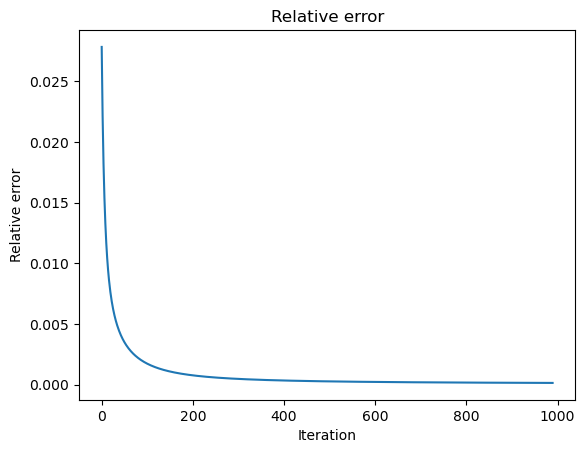

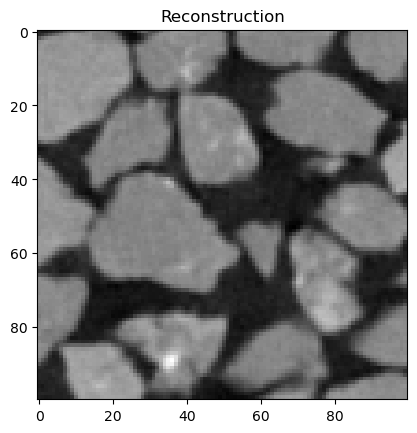

In [78]:
plt.figure()
plt.plot(np.array(rel_err)[10:])
plt.title('Relative error')
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.figure()
plt.imshow(x[300:400, 300:400], cmap='gray')
plt.title('Reconstruction')
#plt.colorbar()
plt.show()

In [54]:
# gradient descent astra
# xk+1 = xk - step * A.T (Axk - y)
y = P.reshape(-1)
x = op.adjoint(y)  # Initial guess
rel_err = []
loss = SquaredL2Norm(dim=P.size).asloss(P.ravel()) * op

for i in range(1000):
    print('Iteration:', i)
    x_next = x - 0.0000005 * loss.grad(x)  # Gradient descent step
    rel_err.append(np.linalg.norm(x_next - x))
    x = x_next

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

[array(154997.71004072), array(6540.22586382), array(4706.84367903), array(3550.21917298), array(2720.77966909), array(2117.03246911), array(1671.83892785), array(1339.52517656), array(1088.38742379), array(896.1292166), array(746.94683525), array(629.58410921), array(535.99103235), array(460.38129574), array(398.56594061), array(347.48294211), array(304.86700103), array(269.01898225), array(238.6454935), array(212.74726757), array(190.54118664), array(171.40540031), array(154.84026449), array(140.44014909), array(127.87279581), array(116.86394825), array(107.18572041), array(98.64768256), array(91.08991026), array(84.37752147), array(78.39631668), array(73.04927946), array(68.25374394), array(63.93907578), array(60.04477327), array(56.51889334), array(53.31674718), array(50.39980869), array(47.73480053), array(45.29292598), array(43.04921859), array(40.98199256), array(39.07237366), array(37.303906), array(35.66220848), array(34.13468964), array(32.7103), array(31.37931978), array(30.

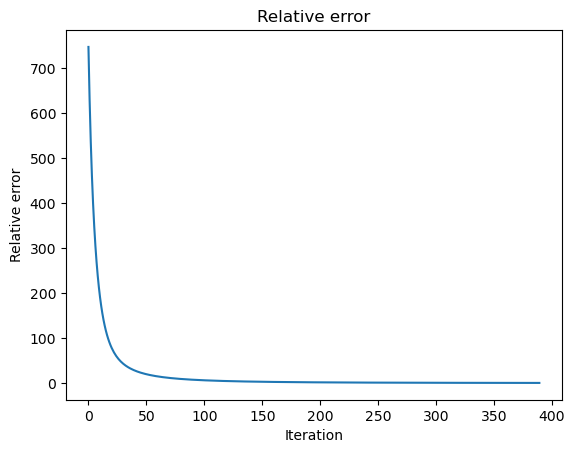

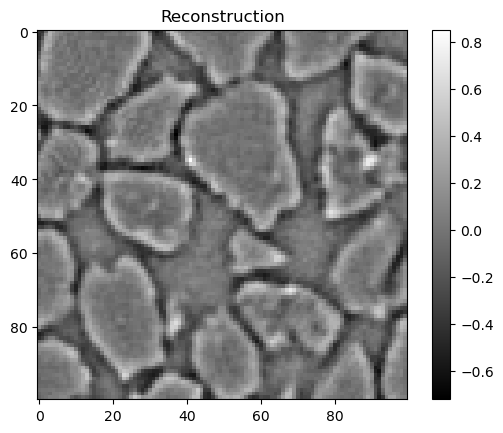

In [43]:
plt.figure()
plt.plot([x.get() for x in rel_err][10:])
plt.title('Relative error')
plt.xlabel('Iteration')
plt.ylabel('Relative error')
print(rel_err)
plt.figure()
plt.imshow(x.reshape(640, 640)[300:400, 300:400].get(), cmap='gray')
plt.title('Reconstruction')
plt.colorbar()
plt.show()

In [2]:

import astra
import numpy as np
import cupy as cp
from cupyx.profiler import benchmark
import matplotlib.pyplot as plt

for N_pix in [250, 5_00, 750, 1000]:

    def fp(x, N_pix=N_pix):
        
        sod=  N_pix
        sdd= 2 * N_pix
        v_shape= N_pix 
        rx_pitch= 1.5

        y = np.random.rand(N_pix, N_pix)
        N_view, N = N_pix, N_pix
        angles = np.linspace(0, 2 * np.pi, num=N_view, endpoint=False)
        proj_geom = astra.create_proj_geom('fanflat', rx_pitch, N, angles, sod, sdd-sod) #source_origin, origin_det
        vol_geom  = astra.create_vol_geom(v_shape,v_shape)

        proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom) #cuda
        volume_id = astra.data2d.create('-vol', vol_geom, x)
        sinogram_id = astra.data2d.create('-sino', proj_geom, 0)
        cfg       = astra.astra_dict('FP')
        cfg['ProjectionDataId']     = sinogram_id
        cfg['VolumeDataId']          = volume_id  
        cfg['ProjectorId']          = proj_id 
        alg_id    = astra.algorithm.create(cfg)
        astra.algorithm.run(alg_id, 1)
        Ax             = astra.data2d.get(sinogram_id)
        return np.array(Ax)
        
    def bp(y, N_pix=N_pix):
        sod=  N_pix
        sdd= 2 * N_pix
        v_shape= N_pix 
        rx_pitch= 1.5

        N_view, N = N_pix, N_pix
        angles = np.linspace(0, 2 * np.pi, num=N_view, endpoint=False)
        proj_geom = astra.create_proj_geom('fanflat', rx_pitch, N, angles, sod, sdd-sod) #source_origin, origin_det
        vol_geom  = astra.create_vol_geom(v_shape,v_shape)

        proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

        sino_id   = astra.data2d.create('-sino', proj_geom, y)
        rec_id    = astra.data2d.create('-vol', vol_geom)
        cfg       = astra.astra_dict('BP')
        cfg['ReconstructionDataId'] = rec_id
        cfg['ProjectionDataId']     = sino_id
        cfg['ProjectorId']          = proj_id
        alg_id    = astra.algorithm.create(cfg)
        astra.algorithm.run(alg_id, 1)
        Aty              = astra.data2d.get(rec_id)
        return np.array(Aty)


    print(f"Benchmarking for N_pix = {N_pix}")
    x = np.random.rand(N_pix, N_pix)
    print(benchmark(
        fp,
        (x,),
        n_repeat=1,
        n_warmup=1
    ))

    y = np.ones((N_pix, N_pix))
    print(benchmark(
        bp,
        (y,),
        n_repeat=1,
        n_warmup=1
    ))


Benchmarking for N_pix = 250
fp                  :    CPU: 110777.806 us     GPU-0: 110794.754 us
bp                  :    CPU: 111095.089 us     GPU-0: 111110.146 us
Benchmarking for N_pix = 500
fp                  :    CPU: 838367.328 us     GPU-0: 838390.808 us
bp                  :    CPU: 838572.703 us     GPU-0: 838592.529 us
Benchmarking for N_pix = 750
fp                  :    CPU: 2907141.108 us     GPU-0: 2907260.010 us
bp                  :    CPU: 2889352.467 us     GPU-0: 2889404.297 us
Benchmarking for N_pix = 1000
fp                  :    CPU: 6861867.037 us     GPU-0: 6862040.039 us
bp                  :    CPU: 6837262.515 us     GPU-0: 6837436.523 us


## arbitrary geom

In [4]:

import astra
import numpy as np
import cupy as cp
from cupyx.profiler import benchmark
import matplotlib.pyplot as plt

for N_pix in [250, 5_00, 750, 1000]:

    def fp(x, N_pix=N_pix):
        
        sod=  N_pix
        sdd= 2 * N_pix
        v_shape= N_pix 
        rx_pitch= 1.5

        y = np.random.rand(N_pix*N_pix, 1)
        N_view, N = N_pix*N_pix, 1
        angles = np.linspace(0, 2 * np.pi, num=N_view, endpoint=False)
        proj_geom = astra.create_proj_geom('fanflat', rx_pitch, N, angles, sod, sdd-sod) #source_origin, origin_det
        vol_geom  = astra.create_vol_geom(v_shape,v_shape)

        proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
        volume_id = astra.data2d.create('-vol', vol_geom, x)
        sinogram_id = astra.data2d.create('-sino', proj_geom, 0)
        cfg       = astra.astra_dict('FP')
        cfg['ProjectionDataId']     = sinogram_id
        cfg['VolumeDataId']          = volume_id  
        cfg['ProjectorId']          = proj_id 
        alg_id    = astra.algorithm.create(cfg)
        astra.algorithm.run(alg_id, 1)
        Ax             = astra.data2d.get(sinogram_id)
        return np.array(Ax)
        
    def bp(y, N_pix=N_pix):
        sod=  N_pix
        sdd= 2 * N_pix
        v_shape= N_pix 
        rx_pitch= 1.5

        N_view, N = N_pix*N_pix, 1
        angles = np.linspace(0, 2 * np.pi, num=N_view, endpoint=False)
        proj_geom = astra.create_proj_geom('fanflat', rx_pitch, N, angles, sod, sdd-sod) #source_origin, origin_det
        vol_geom  = astra.create_vol_geom(v_shape,v_shape)

        proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

        sino_id   = astra.data2d.create('-sino', proj_geom, y)
        rec_id    = astra.data2d.create('-vol', vol_geom)
        cfg       = astra.astra_dict('BP')
        cfg['ReconstructionDataId'] = rec_id
        cfg['ProjectionDataId']     = sino_id
        cfg['ProjectorId']          = proj_id
        alg_id    = astra.algorithm.create(cfg)
        astra.algorithm.run(alg_id, 1)
        Aty              = astra.data2d.get(rec_id)
        return np.array(Aty)


    print(f"Benchmarking for N_pix = {N_pix}")
    x = np.ones((N_pix, N_pix))
    print(benchmark(
        fp,
        (x,),
        n_repeat=1,
        n_warmup=1
    ))

    y = np.ones((N_pix*N_pix, 1))
    print(benchmark(
        bp,
        (y,),
        n_repeat=1,
        n_warmup=1
    ))


Benchmarking for N_pix = 250
fp                  :    CPU: 296029.720 us     GPU-0: 296051.697 us
bp                  :    CPU: 296555.359 us     GPU-0: 296573.944 us
Benchmarking for N_pix = 500
fp                  :    CPU: 1615554.795 us     GPU-0: 1615664.185 us
bp                  :    CPU: 1610072.054 us     GPU-0: 1610116.089 us
Benchmarking for N_pix = 750
fp                  :    CPU: 4589086.149 us     GPU-0: 4589174.805 us
bp                  :    CPU: 4597932.626 us     GPU-0: 4598046.875 us
Benchmarking for N_pix = 1000
fp                  :    CPU: 9891797.211 us     GPU-0: 9891948.242 us
bp                  :    CPU: 9882283.341 us     GPU-0: 9882400.391 us
